<a href="https://colab.research.google.com/github/xqyn/gamlss/blob/main/repli_GAMLSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
# Or clone from github:
! git clone https://github.com/xqyn/R-lib/

In [2]:
# For using R within python
%load_ext rpy2.ipython

In [3]:
%%R
#.libPaths("usr/local/lib/R/site-library/") # if clone from saved  lib in ggdrive
.libPaths('/content/R-lib/') # from github

In [4]:
%%R 
.libPaths()

[1] "/content/R-lib"                "/usr/local/lib/R/site-library"
[3] "/usr/lib/R/site-library"       "/usr/lib/R/library"           


In [5]:
%%script echo skipping
%%R
# For saving installed packages and loading wihout install again in furture (for Colab)
tar("library.tar.gz", "/usr/local/lib/R/site-library") # pack gamlss.dist
tar("library1.tar.gz", "/usr/lib/R/library") # pack MASS

skipping


In [6]:
%%script echo skipping
%cp library.tar.gz /content/drive/MyDrive/Colab/R/gamlss #cp to drive
%cp library1.tar.gz /content/drive/MyDrive/Colab/R/gamlss1 #cp to drive
# Pack MASS and gamlss.dist to R-lib

skipping


In [7]:
%%script echo skipping
# or install manually
%%R
install.packages('gamlss.dist', dependencies = TRUE)

skipping


In [8]:
%%capture
%%R
library(mgcv)
library(reshape2)
library(ggplot2)
library(cowplot)
library(patchwork)
library(viridis)
library(gamlss.dist)

In [9]:
%%capture
%%R
sessionInfo()

In [74]:
%%R
n <- 4000
x <- seq(0, 100, length.out = n)
sigmas <- 0.5 + 1.5*seq(from = -1, to = 1, length.out = n)**2
y  <- 50 + 0.15*x - 0.003*(x**2) + rSHASHo2(n = n, sigma = sigmas,   nu=-1.5, tau=1)

df1 <- data.frame('x' = x, 'y' = y, 'dataset'='Training site')

In [75]:
%%R
m1 <- gam(list(y ~ x, # basically the same model as lm(y~x, data=df1)
                   ~ 1), 
            family=gaulss(),
            data=df1)

m2 <- gam(list(y ~ s(x), # fit mu as a smooth function of x
                   ~ 1), # fit sigma only as an intercept
            family=gaulss(),
            data=df1)

m3 <- gam(list(y ~ s(x), # fit mu as a smooth function of x
                   ~ s(x)), # fit sigma as a smooth function of x
            family=gaulss(),
            data=df1)

m4 <- gam(list(y ~ s(x), # fit mu as a smooth function of x
                   ~ s(x), # fit sigma as a smooth function of x
                   ~ 1, # fit nu (skewness) as an intercept
                   ~ 1), # fit tau (kurtosis) as an intercept
            family=shash(), # shash distribution instead of gaussian 
            data=df1)

In [76]:
%%R
predictions_params_m1 <- predict(m1, newdata = df1)
predictions_params_m2 <- predict(m2, newdata = df1)
predictions_params_m3 <- predict(m3, newdata = df1)
predictions_params_m4 <- predict(m4, newdata = df1)

In [77]:
%%R
#Function
params_to_quantiles_norm <- function(quantiles, params){
  as.data.frame(sapply(quantiles, 
      function(q){
        qnorm(p=q, mean=params[,1], sd = exp(params[,2]))
      }))
}


params_to_quantiles_shash <- function(quantiles, params, qshash){
  as.data.frame(sapply(quantiles, 
      function(q){
        qshash(p=q, 
               # param is called mu, but it expects 
               # a vector of all 4 shash parameters
               mu=params)
      }))
}



In [78]:
%%R

quantiles <- pnorm(c(-2:2))
qshash <- m4$family$qf

predictions_quantiles_m1 <- params_to_quantiles_norm(quantiles, 
                                                     predictions_params_m1)
predictions_quantiles_m2 <- params_to_quantiles_norm(quantiles,
                                                     predictions_params_m2)
predictions_quantiles_m3 <- params_to_quantiles_norm(quantiles, 
                                                     predictions_params_m3)
predictions_quantiles_m4 <- params_to_quantiles_shash(quantiles, 
                                                      predictions_params_m4,
                                                      qshash)

reshape_quantiles_to_long <- function(quantiles_df, x_var){
  quantiles_df$x <- x_var
  return(reshape2::melt(quantiles_df, id.vars = c('x')))
}

predictions_quantiles_m1_long <- reshape_quantiles_to_long(predictions_quantiles_m1, df1$x)
predictions_quantiles_m2_long <- reshape_quantiles_to_long(predictions_quantiles_m2, df1$x)
predictions_quantiles_m3_long <- reshape_quantiles_to_long(predictions_quantiles_m3, df1$x)
predictions_quantiles_m4_long <- reshape_quantiles_to_long(predictions_quantiles_m4, df1$x)

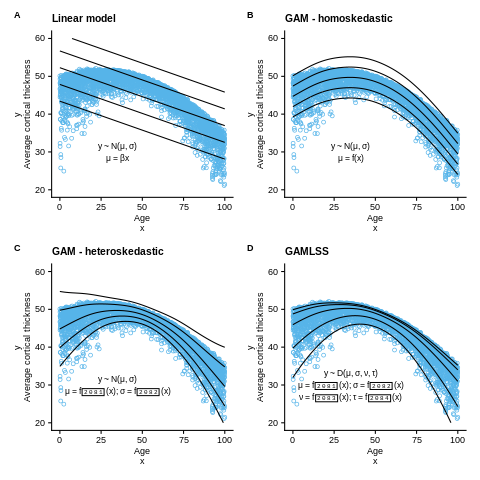

In [79]:
%%R
p1 <- ggplot(df1) +
  geom_point(aes(x=x, y=y), color='#56B4E9', shape=21) +
  geom_line(data=predictions_quantiles_m1_long, aes(x=x, y=value, group=variable)) +
  labs(title='Linear model',
       # subtitle='Mean of y is modeled as a linear function of x',
       x = 'Age\nx', 
       y='y\nAverage cortical thickness')  +
  annotate("text", x = 35, y = 30, size=3,
              label = "y ~ N(μ, σ)\nμ = βx") +
  ylim(c(20,60));

p2 <- ggplot(df1) +
  geom_point(aes(x=x, y=y), color='#56B4E9', shape=21) +
  geom_line(data=predictions_quantiles_m2_long, aes(x=x, y=value, group=variable)) +
  labs(title='GAM - homoskedastic',
       # subtitle='Mean of y is modeled as a smooth function of x',
       x = 'Age\nx', 
       y='y\nAverage cortical thickness')  +
  annotate("text", x = 35, y = 30, size=3,
              label = "y ~ N(μ, σ)\nμ = f(x)") +
  ylim(c(20,60))

p3 <- ggplot(df1) +
  geom_point(aes(x=x, y=y), color='#56B4E9', shape=21) +
  geom_line(data=predictions_quantiles_m3_long, aes(x=x, y=value, group=variable)) +
  labs(title='GAM - heteroskedastic',
       # subtitle='Mean and variance of y are modeled\nas smooth funcitons of x',
       x = 'Age\nx', 
       y='y\nAverage cortical thickness')  +
  annotate("text", x = 35, y = 30, size=3,
              label = "y ~ N(μ, σ)\nμ = f₁(x); σ = f₂(x)") +
  ylim(c(20,60))

p4 <- ggplot(df1) +
  geom_point(aes(x=x, y=y), color='#56B4E9', shape=21) +
  geom_line(data=predictions_quantiles_m4_long, 
            aes(x=x, y=value, group=variable)) +
  labs(title='GAMLSS',
       # subtitle='Location, scale, and shape\nare modeled as functions of x',
       x = 'Age\nx', 
       y='y\nAverage cortical thickness')  + 
  annotate("text", x = 35, y = 30, size=3,
           label = "y ~ D(μ, σ, ν, τ)\nμ = f₁(x); σ = f₂(x)\nν = f₃(x); τ = f₄(x)") +
  ylim(c(20,60))+
  theme_minimal(); 


p_all <- p1 + p2 + p3 + p4 + 
  plot_annotation(tag_levels = 'A') & 
  theme_cowplot() &
  theme(text=element_text(size=9),
                  axis.text = element_text(size=9)); p_all

# ggsave('fig_lm_to_gamls.png',
#        p_all, width = 5, height = 5, units = 'in')

In [80]:
%%R
k <- 100
x<-df1$x
y<-df1$y

contour_cols <- viridis(k, alpha = 0.5)
get_density <- function(x, y, n = 100) {
  dens <- MASS::kde2d(x = x, y = y, n = n)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}

dens <- get_density(x, y, k)
def.par<-par()
#contour_cols

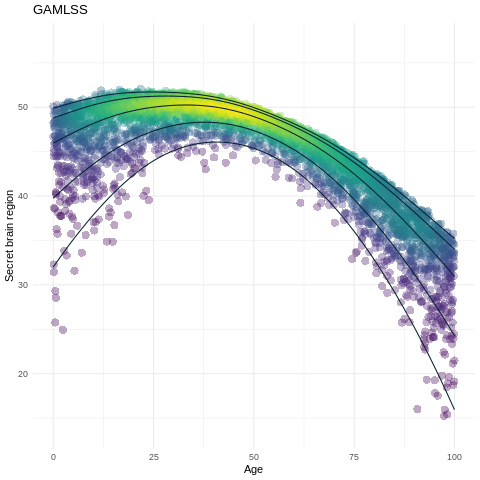

In [86]:
%%R
options(repr.plot.width = 2, repr.plot.height = 40, repr.plot.res = 100)
ggplot(df1) +
  geom_point(aes(x=x, y=y), 
             col = contour_cols[findInterval(dens, seq(0, max(dens), length.out = k))], 
             pch = 16, 
             alpha = .35,
             size=3.5) +
  geom_line(data=predictions_quantiles_m4_long, 
            aes(x=x, y=value, group=variable),
            color='#082133') +
  labs(title='GAMLSS',
       # subtitle='Location, scale, and shape\nare modeled as functions of x',
       x = 'Age', 
       y='Secret brain region')  + 
  annotate("text", x = 35, y = 60, size=8,
           label = expression(paste(
             'y ~ D(',mu,',',sigma,',',nu,',',tau,')',
             )))+
  ylim(c(min(y)*0.9,max(y)*1.1))+
  theme_minimal()

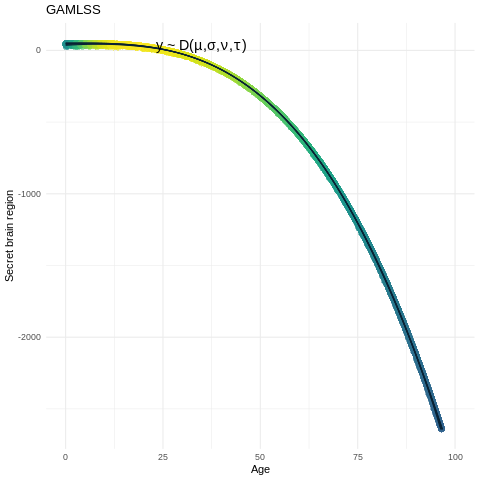

In [135]:
%%R
n <- 5000
x <- seq(0, 100, length.out = n)
sigmas <- 0.75 + 1.5*seq(from = -1, to = 1, length.out = n)**2
y  <- 50 + 0.15*x - 0.003*(x**3) + rSHASHo2(n = n, sigma = sigmas,   nu=-1.5, tau=1)

df_te <- data.frame('x' = x, 'y' = y, 'dataset'='Training site')

m_te <- gam(list(y ~ s(x), # fit mu as a smooth function of x
                   ~ s(x), # fit sigma as a smooth function of x
                   ~ 1, # fit nu (skewness) as an intercept
                   ~ 1), # fit tau (kurtosis) as an intercept
            family=shash(), # shash distribution instead of gaussian 
            data=df_te)

predictions_params_m_te <- predict(m_te, newdata = df_te)

quantiles <- pnorm(c(-2:2))
qshash <- m_te$family$qf

predictions_quantiles_m_te <- params_to_quantiles_shash(quantiles, 
                                                      predictions_params_m_te,
                                                      qshash)

reshape_quantiles_to_long <- function(quantiles_df, x_var){
  quantiles_df$x <- x_var
  return(reshape2::melt(quantiles_df, id.vars = c('x')))
}

predictions_quantiles_m_te_long <- reshape_quantiles_to_long(predictions_quantiles_m_te, df_te$x)



k <- 80
x<-df_te$x
y<-df_te$y

contour_cols <- viridis(k, alpha = 0.5)
get_density <- function(x, y, n = 100) {
  dens <- MASS::kde2d(x = x, y = y, n = n)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}

dens <- get_density(x, y, k)
def.par<-par()
#contour_cols
options(repr.plot.width = 2, repr.plot.height = 40, repr.plot.res = 100)
ggplot(df_te) +
  geom_point(aes(x=x, y=y), 
             col = contour_cols[findInterval(dens, seq(0, max(dens), length.out = k))], 
             pch = 16, 
             size = 3) +
  geom_line(data=predictions_quantiles_m_te_long, 
            aes(x=x, y=value, group=variable),
            color='#082133') +
  labs(title='GAMLSS',
       # subtitle='Location, scale, and shape\nare modeled as functions of x',
       x = 'Age', 
       y='Secret brain region')  + 
  annotate("text", x = 35, y = 30, size=5,
           label = expression(paste(
             'y ~ D(',mu,',',sigma,',',nu,',',tau,')',
             )))+
  ylim(c(min(y)*0.9,max(y)*1.1))+
  theme_minimal()


In [90]:
%%R
n <- 5000
x <- seq(0, 100, length.out = n)
sigmas <- 0.75 + 1.5*seq(from = -1, to = 1, length.out = n)**2
y  <- 50 + 0.15*x - 0.2*(x**2) + rSHASHo2(n = n, sigma = sigmas,   nu=-1.5, tau=1)

df_te <- data.frame('x' = x, 'y' = y, 'dataset'='Training site')

m_te <- gam(list(y ~ s(x), # fit mu as a smooth function of x
                   ~ s(x), # fit sigma as a smooth function of x
                   ~ 1, # fit nu (skewness) as an intercept
                   ~ 1), # fit tau (kurtosis) as an intercept
            family=shash(), # shash distribution instead of gaussian 
            data=df_te)

predictions_params_m_te <- predict(m_te, newdata = df_te)

quantiles <- pnorm(c(-2:2))
qshash <- m_te$family$qf

predictions_quantiles_m_te <- params_to_quantiles_shash(quantiles, 
                                                      predictions_params_m_te,
                                                      qshash)

reshape_quantiles_to_long <- function(quantiles_df, x_var){
  quantiles_df$x <- x_var
  return(reshape2::melt(quantiles_df, id.vars = c('x')))
}

predictions_quantiles_m_te_long <- reshape_quantiles_to_long(predictions_quantiles_m_te, df_te$x)



k <- 80
x<-df_te$x
y<-df_te$y

contour_cols <- viridis(k, alpha = 0.5)
get_density <- function(x, y, n = 100) {
  dens <- MASS::kde2d(x = x, y = y, n = n)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}

dens <- get_density(x, y, k)
def.par<-par()
#contour_cols
#%%R


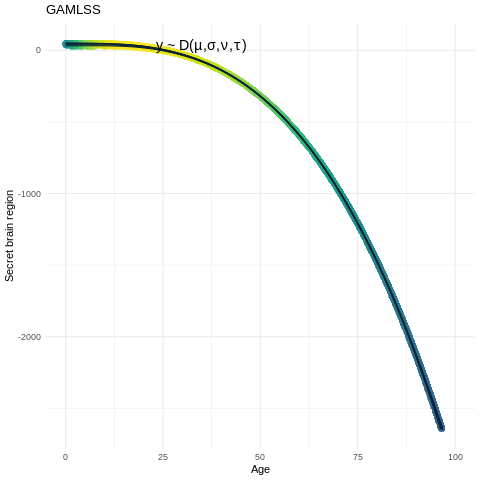

In [89]:
%%R
options(repr.plot.width = 2, repr.plot.height = 40, repr.plot.res = 100)
ggplot(df_te) +
  geom_point(aes(x=x, y=y), 
             col = contour_cols[findInterval(dens, seq(0, max(dens), length.out = k))], 
             pch = 16, 
             size = 3) +
  geom_line(data=predictions_quantiles_m_te_long, 
            aes(x=x, y=value, group=variable),
            color='#082133') +
  labs(title='GAMLSS',
       # subtitle='Location, scale, and shape\nare modeled as functions of x',
       x = 'Age', 
       y='Secret brain region')  + 
  annotate("text", x = 35, y = 30, size=5,
           label = expression(paste(
             'y ~ D(',mu,',',sigma,',',nu,',',tau,')',
             )))+
  ylim(c(min(y)*0.9,max(y)*1.1))+
  theme_minimal()

In [132]:
%%R
n <- 2000
x <- seq(0, 100, length.out = n)
sigmas <- 0.75 + 1.5*seq(from = -1, to = 1, length.out = n)**2
y  <- 50 + 0.15*x - 0.003*(x**2) + rSHASHo2(n = n, sigma = sigmas,   nu=-1.5, tau=10)

df_te <- data.frame('x' = x, 'y' = y, 'dataset'='Training site')

m_te <- gam(list(y ~ s(x), # fit mu as a smooth function of x
                   ~ s(x), # fit sigma as a smooth function of x
                   ~ 1, # fit nu (skewness) as an intercept
                   ~ 1), # fit tau (kurtosis) as an intercept
            family=shash(), # shash distribution instead of gaussian 
            data=df_te)

predictions_params_m_te <- predict(m_te, newdata = df_te)

quantiles <- pnorm(c(-2:2))
qshash <- m_te$family$qf

predictions_quantiles_m_te <- params_to_quantiles_shash(quantiles, 
                                                      predictions_params_m_te,
                                                      qshash)

reshape_quantiles_to_long <- function(quantiles_df, x_var){
  quantiles_df$x <- x_var
  return(reshape2::melt(quantiles_df, id.vars = c('x')))
}

predictions_quantiles_m_te_long <- reshape_quantiles_to_long(predictions_quantiles_m_te, df_te$x)



k <- 80
x<-df_te$x
y<-df_te$y

contour_cols <- viridis(k, alpha = 0.5)
get_density <- function(x, y, n = 100) {
  dens <- MASS::kde2d(x = x, y = y, n = n)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}

dens <- get_density(x, y, k)
def.par<-par()
#contour_cols
#%%R


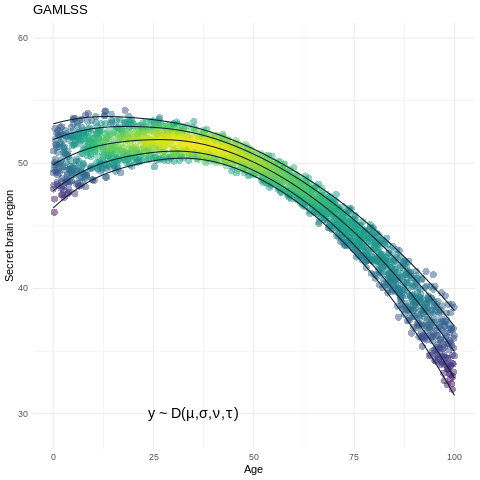

In [125]:
%%R
options(repr.plot.width = 2, repr.plot.height = 40, repr.plot.res = 100)
ggplot(df_te) +
  geom_point(aes(x=x, y=y), 
             col = contour_cols[findInterval(dens, seq(0, max(dens), length.out = k))], 
             pch = 16, 
             size = 3) +
  geom_line(data=predictions_quantiles_m_te_long, 
            aes(x=x, y=value, group=variable),
            color='#082133') +
  labs(title='GAMLSS',
       # subtitle='Location, scale, and shape\nare modeled as functions of x',
       x = 'Age', 
       y='Secret brain region')  + 
  annotate("text", x = 35, y = 30, size=5,
           label = expression(paste(
             'y ~ D(',mu,',',sigma,',',nu,',',tau,')',
             )))+
  ylim(c(min(y)*0.9,max(y)*1.1))+
  theme_minimal()

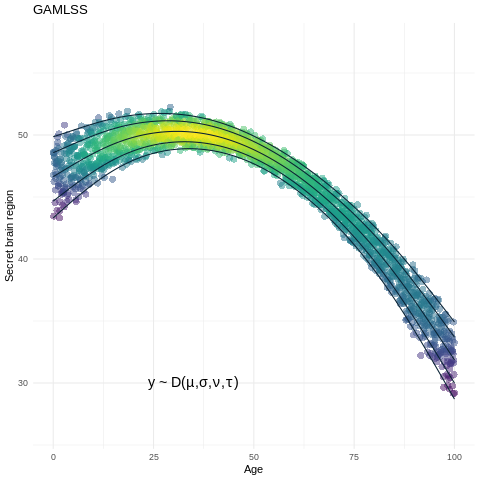

In [133]:
%%R
options(repr.plot.width = 2, repr.plot.height = 40, repr.plot.res = 100)
ggplot(df_te) +
  geom_point(aes(x=x, y=y), 
             col = contour_cols[findInterval(dens, seq(0, max(dens), length.out = k))], 
             pch = 16, 
             size = 3) +
  geom_line(data=predictions_quantiles_m_te_long, 
            aes(x=x, y=value, group=variable),
            color='#082133') +
  labs(title='GAMLSS',
       # subtitle='Location, scale, and shape\nare modeled as functions of x',
       x = 'Age', 
       y='Secret brain region')  + 
  annotate("text", x = 35, y = 30, size=5,
           label = expression(paste(
             'y ~ D(',mu,',',sigma,',',nu,',',tau,')',
             )))+
  ylim(c(min(y)*0.9,max(y)*1.1))+
  theme_minimal()